In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

In [2]:
N = 16
two_N = 32
nearest_square = 36
sqrt_N = 6

n = torch.arange(nearest_square)
omegas = torch.exp(2j * torch.pi * n / nearest_square)

In [20]:
def ref_dft_matrix(N):
    """Compute the DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    M = torch.exp(-2j * torch.pi * n * k / N)
    return torch.view_as_real(M)

def ref_idft_matrix(N):
    """Compute the inverse DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    M = torch.exp(2j * torch.pi * n * k / N) / N
    return torch.view_as_real(M)

def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += str(poly[i])
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

In [4]:
def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += f'{round(poly[i], 2)}'
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

def get_P_matrix(N, sqrt_N):
    idx = torch.arange(N)
    idx = rearrange(idx, '(m n) -> (n m)', m = sqrt_N)

    P = torch.diag(torch.ones(N))[idx]

    return P

# Try Block Monarch

In [79]:
R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

block_FFT_sqrt_N = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
FFT_sqrt_N = torch.view_as_complex(ref_dft_matrix(sqrt_N))
L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

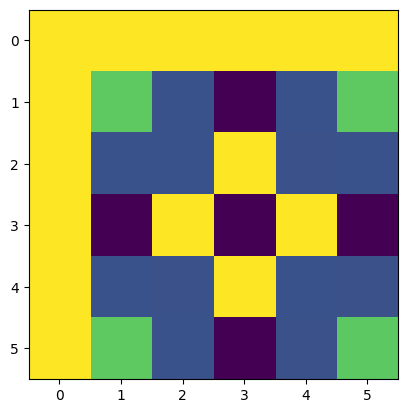

In [81]:
plt.imshow(FFT_sqrt_N.real)

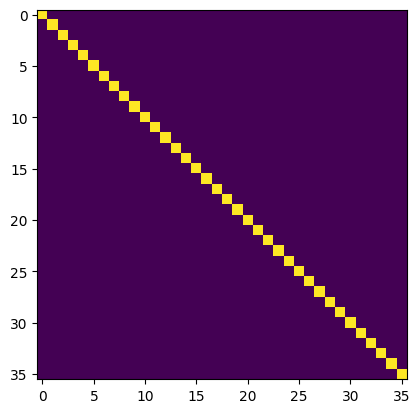

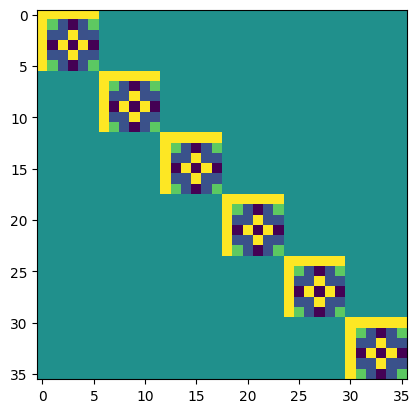

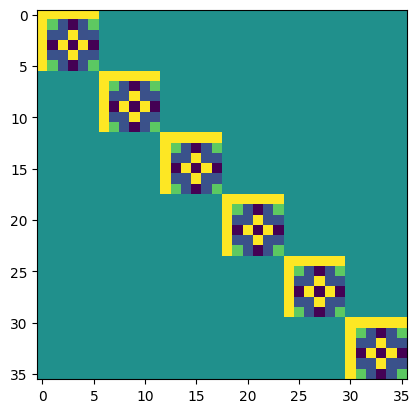

In [143]:
R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

for i in range(sqrt_N):
    # R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
    R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
    block_FFT_sqrt_N[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = FFT_sqrt_N
plt.imshow(R.real)
plt.show()
plt.imshow(block_FFT_sqrt_N.real)
plt.show()

R = block_FFT_sqrt_N @ R
plt.imshow(R.real)

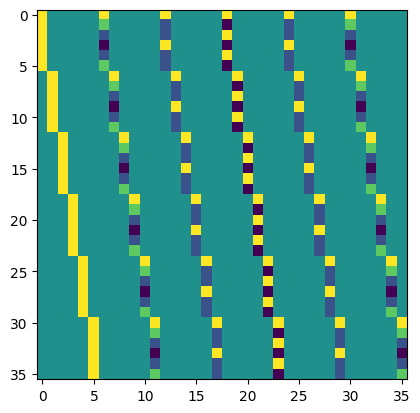

In [144]:
P = get_P_matrix(nearest_square, sqrt_N).to(torch.cfloat)
R_diag = R
R = R @ P

plt.imshow(R.real)

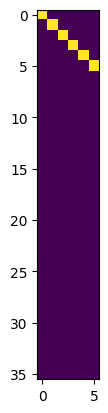

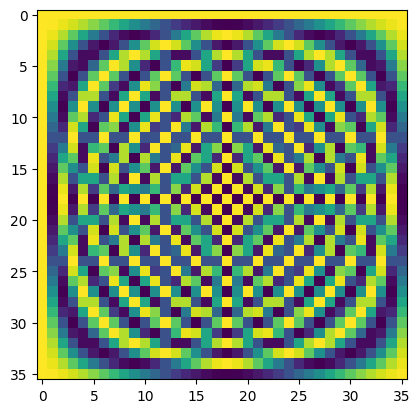

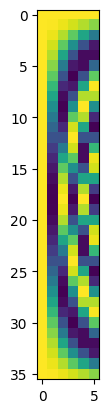

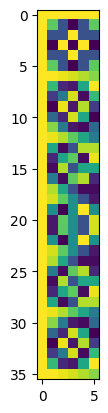

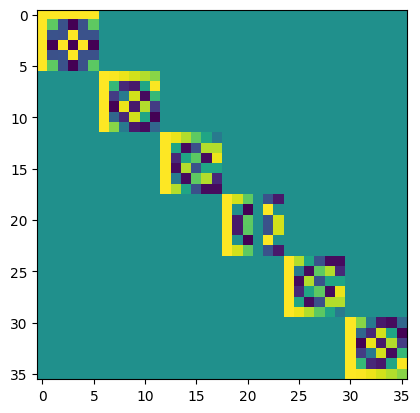

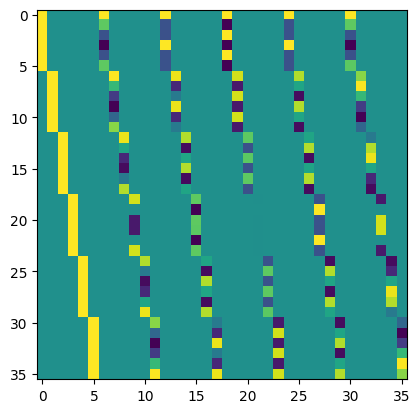

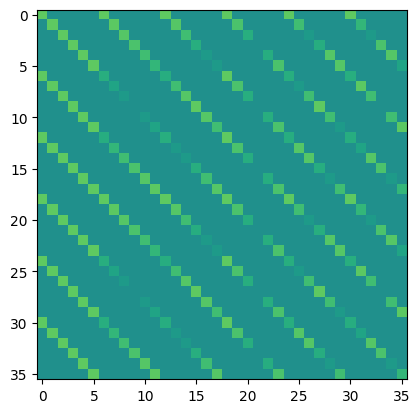

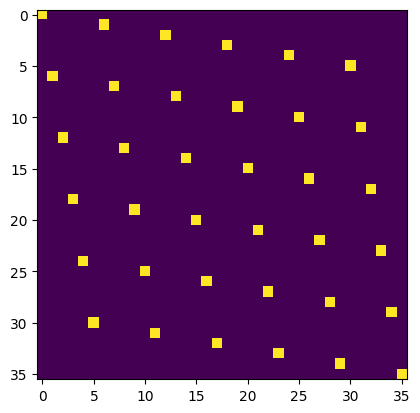

In [332]:
L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

# L_tilde_orig[:sqrt_N, :] = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
L_tilde_orig[:sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))

plt.imshow(L_tilde_orig.real)
plt.show()

FFT_n = torch.view_as_complex(ref_dft_matrix(nearest_square))

plt.imshow(FFT_n.real)
plt.show()

plt.imshow((FFT_n @ L_tilde_orig).real)
plt.show()

L_tilde = P @ FFT_n @ L_tilde_orig

plt.imshow(L_tilde.real)
plt.show()

for i in range(sqrt_N):
    L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]
    # L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = block_FFT_sqrt_N

# L = block_FFT_sqrt_N
L_diag = L

plt.imshow(L_diag.real)
plt.show()

L = L_diag @ P

plt.imshow(L.real)
plt.show()

L = P @ L
plt.imshow(torch.abs(L.real), vmin=-2, vmax=2)
plt.show()

plt.imshow(P.real)
plt.show()

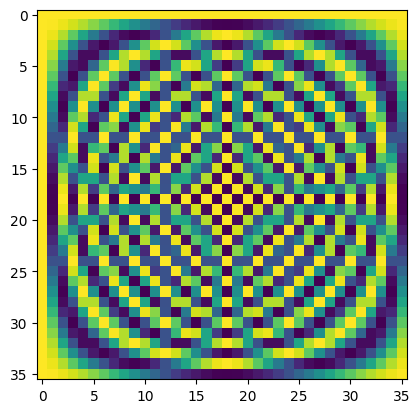

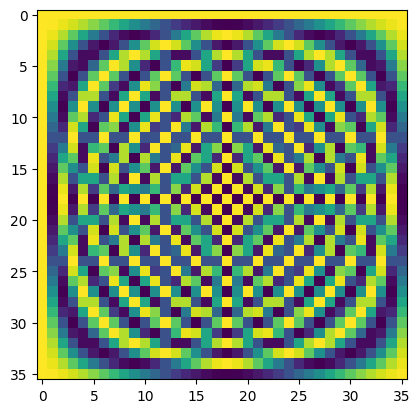

In [164]:
M = P @ L_diag @ P @ R_diag @ P
plt.imshow(M.real)

plt.show()
plt.imshow((FFT_n).real)

In [299]:
def block_monarch(nearest_square, sqrt_N):
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    block_FFT_sqrt_N = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    FFT_sqrt_N = torch.view_as_complex(ref_dft_matrix(sqrt_N))
    L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)
    R_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

    # set values for R
    for i in range(sqrt_N):
        block = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
        block[int(sqrt_N / 2):, :int(sqrt_N / 2)] = 0
        # block = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        block += torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        R_tilde_orig[i * sqrt_N:(i + 1) * sqrt_N, :] = block
        # R_tilde_orig[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        block_FFT_sqrt_N[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = FFT_sqrt_N
    
    R_tilde = R_tilde_orig

    for i in range(sqrt_N):
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]

    R = block_FFT_sqrt_N @ R

    P = get_P_matrix(nearest_square, sqrt_N).to(torch.cfloat)
    R_diag = R
    R = R @ P

    # set values for L
    L_tilde_orig[:sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat)) + torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
    # L_tilde_orig[:sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
    L_tilde = P @ torch.view_as_complex(ref_dft_matrix(nearest_square)) @ L_tilde_orig
    for i in range(sqrt_N):
        L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]
    
    L_diag = L

    L = P @ L @ P

    M = L @ R

    return L, R, M, L_diag, R_diag, R_tilde_orig, L_tilde_orig

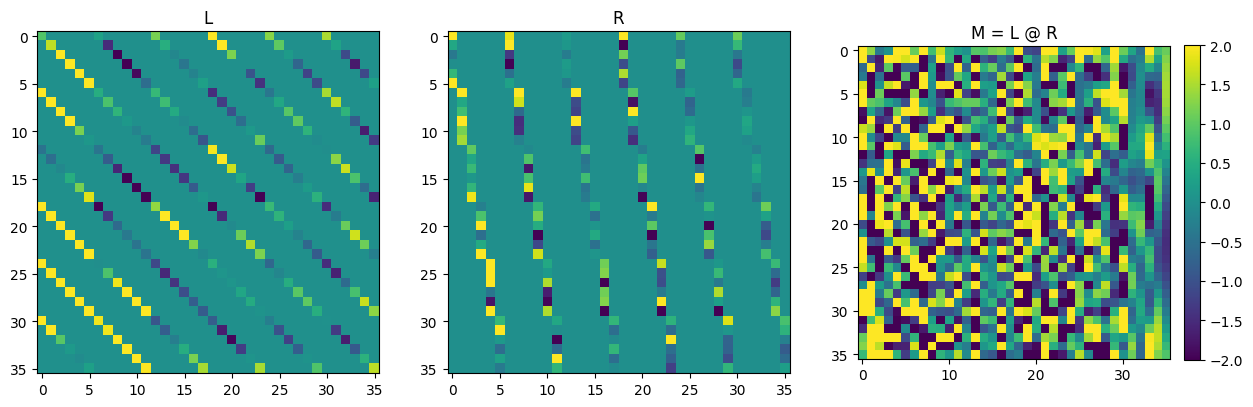

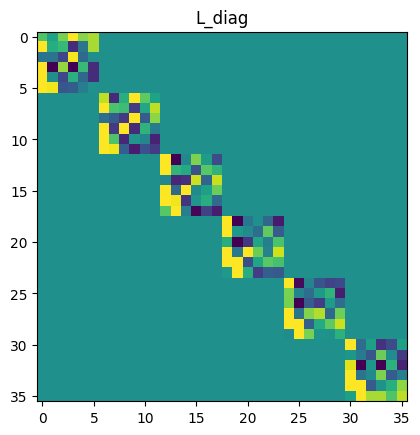

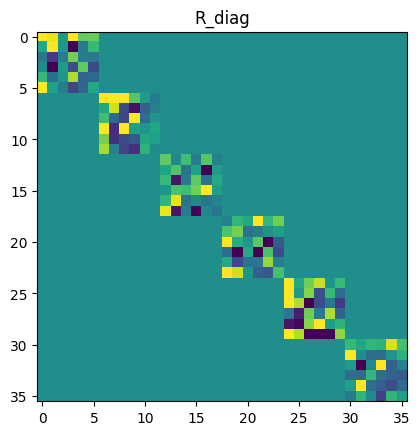

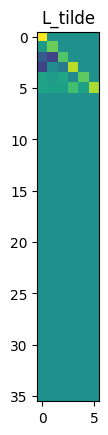

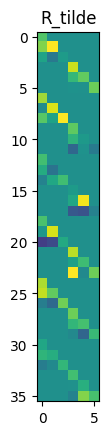

In [300]:
L, R, M, L_diag, R_diag, R_tilde, L_tilde = block_monarch(nearest_square, sqrt_N)
plot_monarch(L.real, R.real, M.real)
plt.show()

plt.title('L_diag')
plt.imshow(L_diag.real, vmin=-2, vmax=2)
plt.show()

plt.title('R_diag')
plt.imshow(R_diag.real, vmin=-2, vmax=2)
plt.show()

plt.title('L_tilde')
plt.imshow(L_tilde.real, vmin=-2, vmax=2)
plt.show()

plt.title('R_tilde')
plt.imshow(R_tilde.real, vmin=-2, vmax=2)
plt.show()

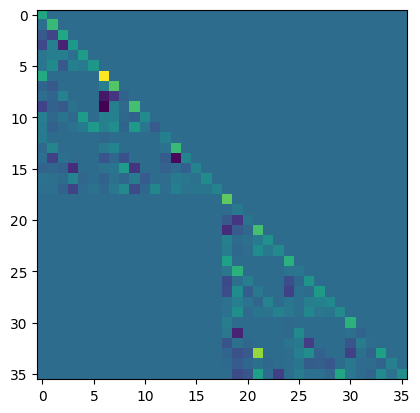

In [301]:
plt.imshow((torch.view_as_complex(ref_idft_matrix(M.shape[0])) @ M).real)

In [302]:
# test causality by changing the last element of u, and seeing if the output changes

u = torch.randn(N)
k = torch.randn(N)

M1 = M
M2 = M
M3 = torch.linalg.inv(M)
# M3 = torch.view_as_complex(ref_idft_matrix(M.shape[0]))
# M3 = M

y = new_monarch_fft_conv(u, k, N, M1, M2, M3)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(new_monarch_fft_conv(u_changed, k, N, M1, M2, M3))

new_ys = torch.stack(new_ys)

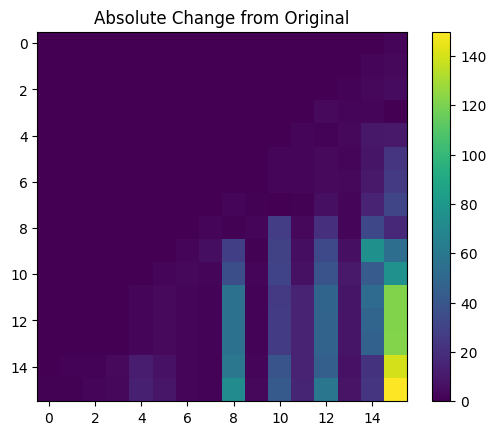

In [303]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()

# Expressivity

Check expressivity of regular convolution, Monarch convolutions

## Regular Convolution

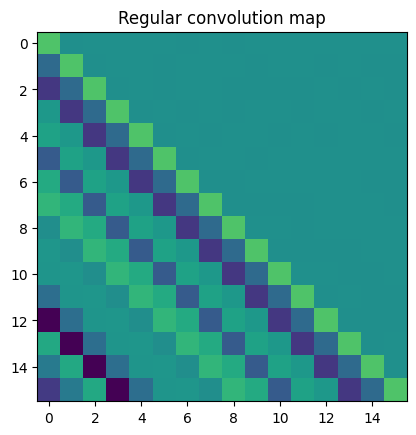

In [334]:
pad_mat = torch.zeros(2 * N, N, dtype=torch.cfloat)
pad_mat[:N, :] = torch.diag(torch.ones(N, dtype=torch.cfloat))

unpad_mat = pad_mat.T

fft_2n = torch.view_as_complex(ref_dft_matrix(2 * N))
ifft_2n = torch.view_as_complex(ref_idft_matrix(2 * N))
K_f = fft_2n @ pad_mat @ k.to(torch.cfloat)

K_f_diag = torch.diag(K_f)

conv_map = unpad_mat @ ifft_2n @ K_f_diag @ fft_2n @ pad_mat

plt.title('Regular convolution map')
plt.imshow(conv_map.real, vmin=-2, vmax=2)

In [335]:
K_f

tensor([-5.1475+0.0000e+00j,  2.9292+2.6821e+00j, -2.3748-2.9103e+00j,
        -1.6021+5.1573e+00j,  3.4457+1.2290e+00j,  0.2480-4.8322e-01j,
        -0.3321+2.5107e+00j,  3.6353+1.4219e+00j, -0.7768-1.7000e-01j,
         4.5633+5.1329e+00j,  5.3185-5.2250e+00j, -1.8478-7.8892e-02j,
         3.9438-1.5035e+00j, -2.8858-2.3241e+00j,  1.0652+3.0431e+00j,
         2.1438-1.6624e+00j, -1.0640+4.2603e-07j,  2.1438+1.6624e+00j,
         1.0652-3.0431e+00j, -2.8858+2.3241e+00j,  3.9438+1.5035e+00j,
        -1.8477+7.8897e-02j,  5.3185+5.2250e+00j,  4.5633-5.1329e+00j,
        -0.7768+1.7000e-01j,  3.6352-1.4219e+00j, -0.3321-2.5107e+00j,
         0.2480+4.8323e-01j,  3.4457-1.2290e+00j, -1.6021-5.1573e+00j,
        -2.3748+2.9103e+00j,  2.9292-2.6821e+00j])

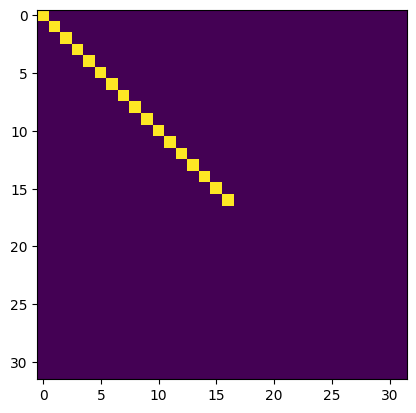

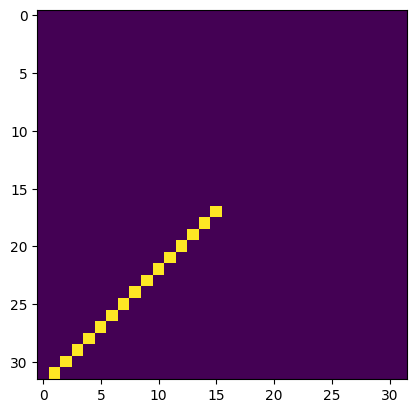

In [349]:
pivot = torch.diag(torch.ones(32, dtype=torch.cfloat))
pivot[17:] = 0.
pivot[17:, 1:16] = torch.flip(torch.diag(torch.ones(15, dtype=torch.cfloat) * 1j), (0,))
plt.imshow(pivot.real)
plt.show()
plt.imshow(pivot.imag)
plt.show()

In [350]:
print(K_f)
print(pivot @ K_f)

tensor([-5.1475+0.0000e+00j,  2.9292+2.6821e+00j, -2.3748-2.9103e+00j,
        -1.6021+5.1573e+00j,  3.4457+1.2290e+00j,  0.2480-4.8322e-01j,
        -0.3321+2.5107e+00j,  3.6353+1.4219e+00j, -0.7768-1.7000e-01j,
         4.5633+5.1329e+00j,  5.3185-5.2250e+00j, -1.8478-7.8892e-02j,
         3.9438-1.5035e+00j, -2.8858-2.3241e+00j,  1.0652+3.0431e+00j,
         2.1438-1.6624e+00j, -1.0640+4.2603e-07j,  2.1438+1.6624e+00j,
         1.0652-3.0431e+00j, -2.8858+2.3241e+00j,  3.9438+1.5035e+00j,
        -1.8477+7.8897e-02j,  5.3185+5.2250e+00j,  4.5633-5.1329e+00j,
        -0.7768+1.7000e-01j,  3.6352-1.4219e+00j, -0.3321-2.5107e+00j,
         0.2480+4.8323e-01j,  3.4457-1.2290e+00j, -1.6021-5.1573e+00j,
        -2.3748+2.9103e+00j,  2.9292-2.6821e+00j])
tensor([-5.1475+0.0000e+00j,  2.9292+2.6821e+00j, -2.3748-2.9103e+00j,
        -1.6021+5.1573e+00j,  3.4457+1.2290e+00j,  0.2480-4.8322e-01j,
        -0.3321+2.5107e+00j,  3.6353+1.4219e+00j, -0.7768-1.7000e-01j,
         4.5633+5.1329e+00

## Monarch Convolution, with R fixed

For this one, let the R's be the identity, and let L be free.

In [274]:
def block_monarch_r_id(nearest_square, sqrt_N):
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    block_FFT_sqrt_N = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    FFT_sqrt_N = torch.view_as_complex(ref_dft_matrix(sqrt_N))
    L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)
    R_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

    # set values for R
    for i in range(sqrt_N):
        # block = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
        block = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        block.fill_diagonal_(1)
        R_tilde_orig[i * sqrt_N:(i + 1) * sqrt_N, :] = block
        # R_tilde_orig[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        block_FFT_sqrt_N[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = FFT_sqrt_N
    
    R_tilde = R_tilde_orig

    for i in range(sqrt_N):
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]

    R = block_FFT_sqrt_N @ R

    P = get_P_matrix(nearest_square, sqrt_N).to(torch.cfloat)
    R_diag = R
    R = R @ P

    # set values for L
    L_tilde_orig[:sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat)) + torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
    # L_tilde_orig[:sqrt_N, :] = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
    L_tilde = P @ torch.view_as_complex(ref_dft_matrix(nearest_square)) @ L_tilde_orig
    for i in range(sqrt_N):
        L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]
    
    L_diag = L

    L = P @ L @ P

    M = L @ R

    return L, R, M, L_diag, R_diag, R_tilde_orig, L_tilde_orig

In [275]:
L, R, M, L_diag, R_diag, R_tilde_orig, L_tilde_orig = block_monarch_r_id(nearest_square, sqrt_N)

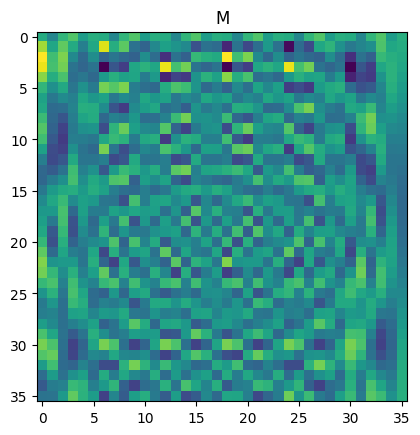

In [276]:
plt.title('M')
plt.imshow(M.real)

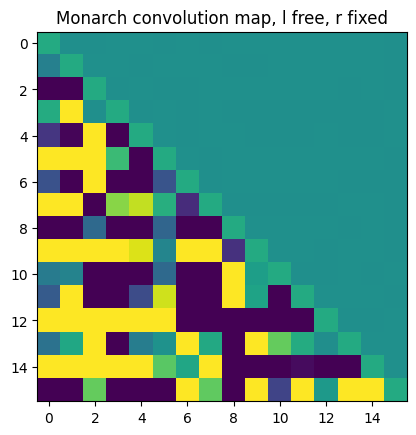

In [354]:
pad_mat = torch.zeros(nearest_square, N, dtype=torch.cfloat)
pad_mat[:N, :] = torch.diag(torch.ones(N, dtype=torch.cfloat))

unpad_mat = pad_mat.T

M_cut = M[:, :N]

M_inv = torch.linalg.inv(M)[:N, :]
K_f = M_cut @ k.to(torch.cfloat)

K_f_diag = torch.diag(K_f)

conv_map = M_inv @ K_f_diag @ M_cut

plt.title('Monarch convolution map, l free, r fixed')
plt.imshow(conv_map.real, vmin=-2, vmax=2)

# Monarch Convolution, with l and r free

In [304]:
L, R, M, L_diag, R_diag, R_tilde_orig, L_tilde_orig = block_monarch(nearest_square, sqrt_N)

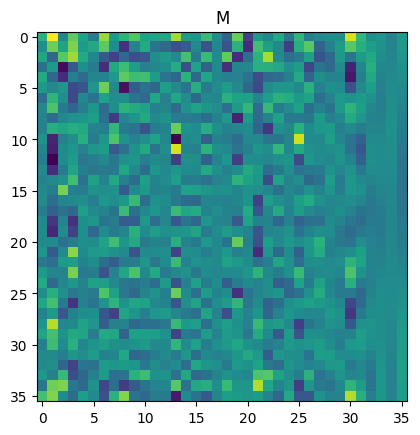

In [305]:
plt.title('M')
plt.imshow(M.real)

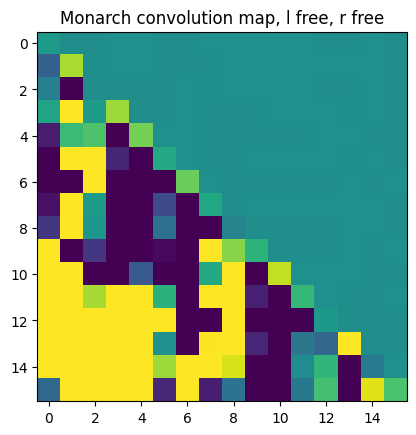

In [307]:
pad_mat = torch.zeros(nearest_square, N, dtype=torch.cfloat)
pad_mat[:N, :] = torch.diag(torch.ones(N, dtype=torch.cfloat))

unpad_mat = pad_mat.T

# M_inv = torch.linalg.inv(M)
M_inv = torch.view_as_complex(ref_idft_matrix(nearest_square))
K_f = M @ pad_mat @ k.to(torch.cfloat)

K_f_diag = torch.diag(K_f)

conv_map = unpad_mat @ M_inv @ K_f_diag @ M @ pad_mat

plt.title('Monarch convolution map, l free, r free')
plt.imshow(conv_map.real, vmin=-2, vmax=2)

In [333]:
K_f

tensor([ -4.6722+2.6658j,   5.4235+3.9976j, -14.9020-0.4510j,
          9.1058+30.1093j,  25.2265-14.2111j,  -9.7924-8.2736j,
          3.1301-0.0794j,  -7.3911-5.2665j,  -6.6884+7.6469j,
          1.8881+9.7972j,   8.1096+5.2228j,   8.0224-1.0337j,
          2.7582-3.4011j,   6.0648-0.2826j,   0.1827-13.4601j,
        -13.3537+5.2997j,   7.3298+6.5219j,  -0.8751+0.5566j,
          7.2914+2.8946j,  -0.3646+0.4957j,  15.6009+2.6087j,
         -1.1397-18.3923j,  -5.4249+7.1480j,   6.6334-6.2341j,
         -5.0216+2.2896j,  10.8894-0.4823j,   0.9867-10.8119j,
         -4.4475-5.2808j,  -2.7782+0.0858j,   0.3366-3.6680j,
         -4.2888-0.8317j,   1.6571+0.9659j,   5.5196-5.4875j,
         -7.8436-18.6132j, -24.2126+7.3313j,   3.3334+11.9864j])

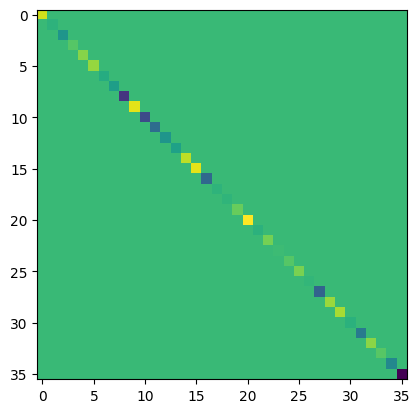

In [313]:
plt.imshow((torch.linalg.inv(P) @ torch.diag(torch.randn(P.shape[0], dtype=torch.cfloat)) @ P).real)

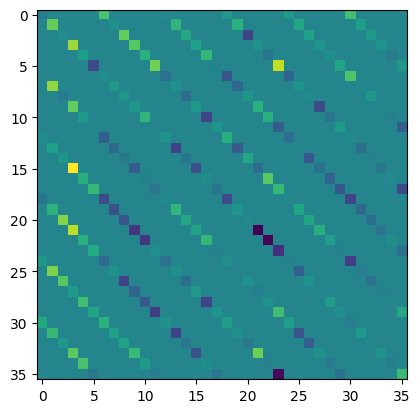

In [315]:
plt.imshow((P @ R_diag @ torch.linalg.inv(P)).real)

In [316]:
R_diag

tensor([[-0.2406-1.2131j,  2.1594-0.7455j,  0.1752-0.6300j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0199-0.1313j,  0.2646-1.9912j, -0.6333+0.1633j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.3663-0.7980j, -1.2894-1.2039j,  0.4580+0.4668j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -2.6411-1.0955j, -0.1342-1.0892j, -0.6426-1.8040j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          1.9950+1.4888j,  0.3951+0.3062j,  1.2410-1.4585j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -3.5526-1.9765j, -0.6645-0.4049j,  1.8836+0.3455j]])

In [317]:
middle = torch.diag(torch.randn(P.shape[0], dtype=torch.cfloat))

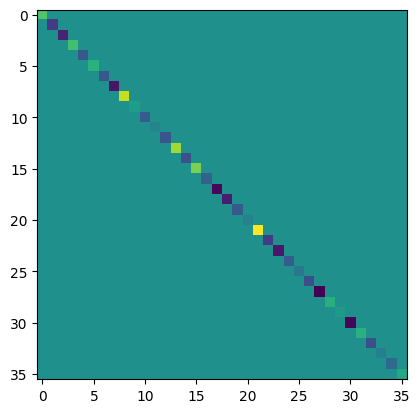

In [321]:
plt.imshow(middle.real)

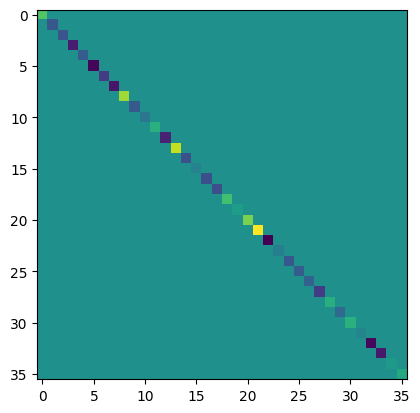

In [330]:
plt.imshow((torch.linalg.inv(P) @ middle @ P).real)

In [319]:
dft_n = torch.view_as_complex(ref_dft_matrix(nearest_square))
idft_n = torch.view_as_complex(ref_idft_matrix(nearest_square))

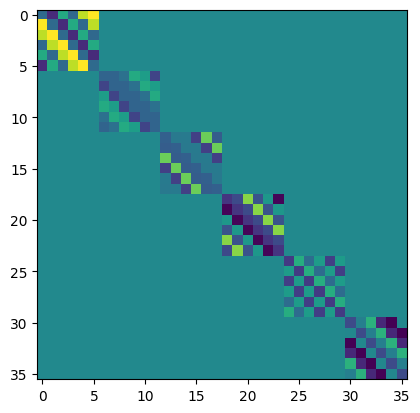

In [323]:
plt.imshow((block_FFT_sqrt_N @ middle @ torch.linalg.inv(block_FFT_sqrt_N)).real)

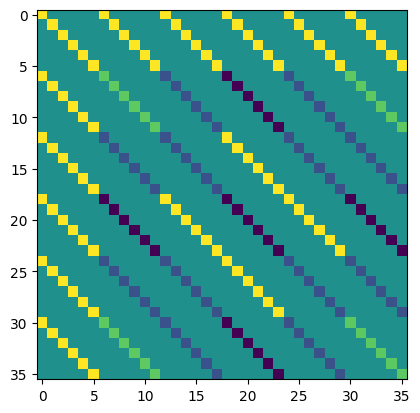

In [324]:
plt.imshow((torch.linalg.inv(P) @ block_FFT_sqrt_N @ P).real)

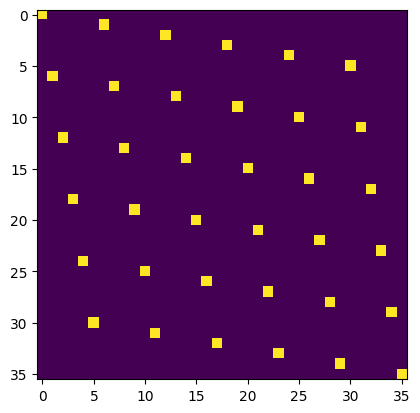

In [325]:
plt.imshow(torch.linalg.inv(P).real)

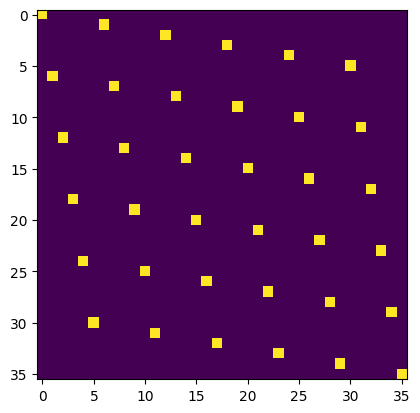

In [326]:
plt.imshow(P.real)